<a href="https://colab.research.google.com/github/antoinebossan1/Codes-for-Kaggle-Competitions/blob/main/Comparing-Machine-Learning-Algorithms-Spaceship-Titanic-Kaggle-Competitions/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import files

# Set up Kaggle API


In [2]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c spaceship-titanic
!unzip spaceship-titanic.zip

Saving kaggle.json to kaggle.json
  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 90.7MB/s]
Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Load Data

In [3]:
train_data = pd.read_csv('train.csv')

# Data exploration 

In [4]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Separate numerical and categorical features

In [6]:
num_features = train_data.select_dtypes(include=['number']).columns.tolist()
cat_features = train_data.select_dtypes(exclude=['number']).columns.tolist()
train_num = train_data[num_features]
train_cat = train_data[cat_features]

# Identify columns with missing values

In [7]:
train_data_missing_values = train_data.isnull().sum()
train_data_missing_values

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
train_data_columns_with_missing_values = [col for col in train_data.columns if train_data_missing_values[col] > 0]
train_data_columns_with_missing_values

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name']

# Data Analysis 

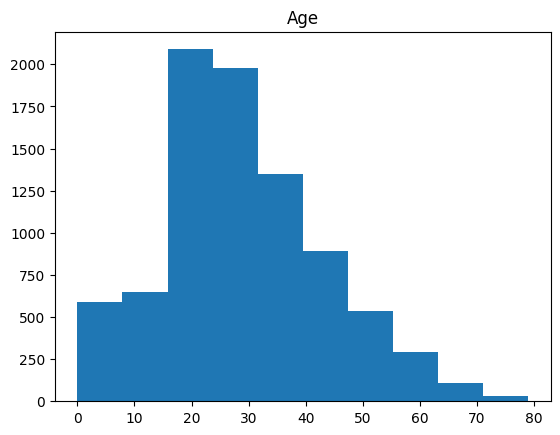

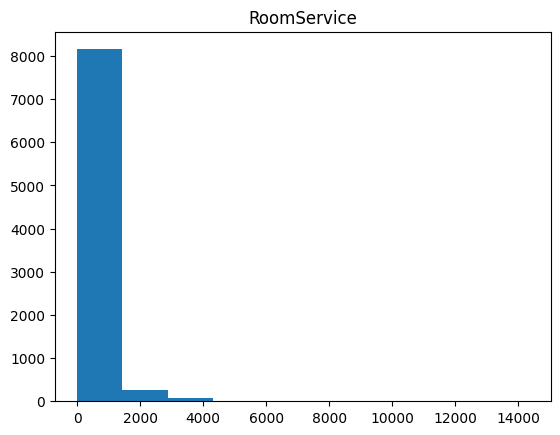

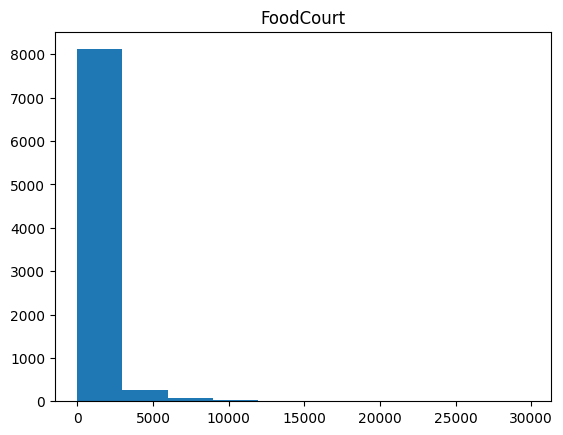

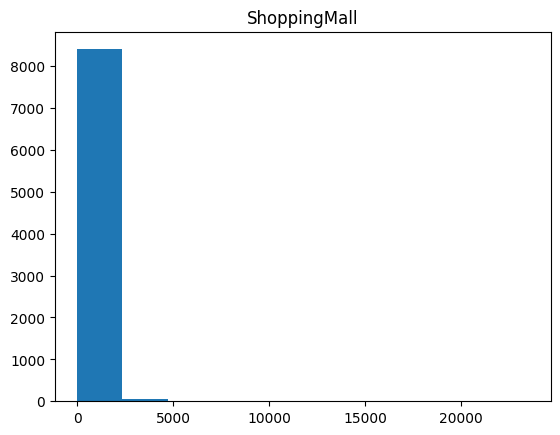

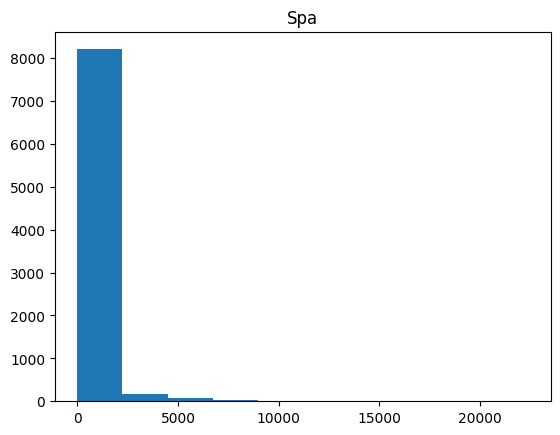

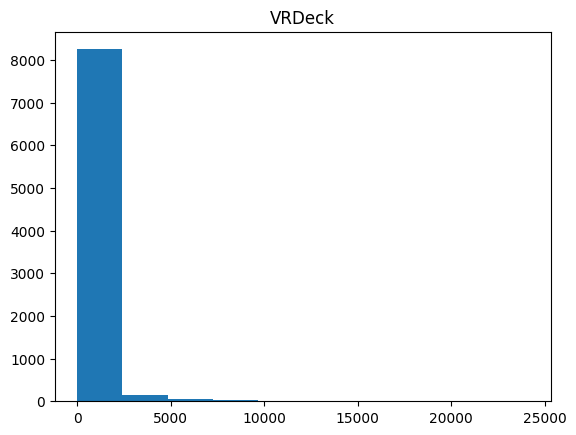

In [9]:
for i in train_num.columns:
    plt.hist(train_num[i])
    plt.title(i)
    plt.show()


# Correlation table

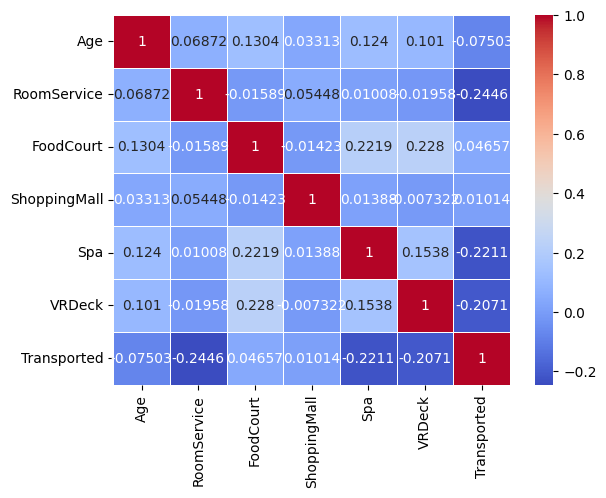

In [10]:
correlation_table = train_data.corr(numeric_only=True)
sns.heatmap(correlation_table, annot=True, fmt='.4g', cmap='coolwarm', linewidths=0.5)
plt.show()

Analyzing the correlation heatmap, we can observe the strongest relationships between 'CryoSleep' and the 'Transported' outcome.




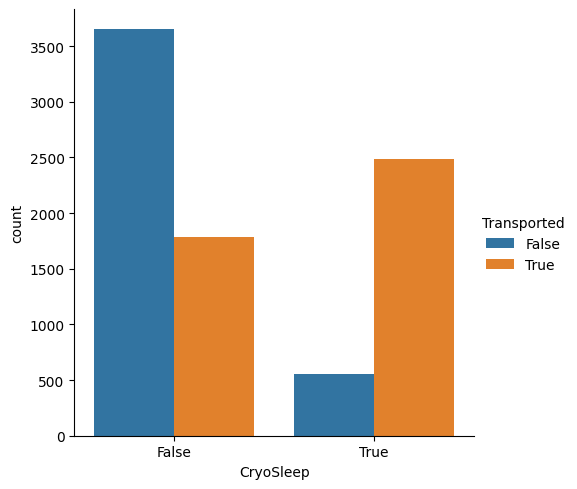

In [11]:
sns.catplot(x="CryoSleep", hue="Transported", kind="count", data=train_data)


We can see that most of the people for whom the 'CryoSleep' variable was true were transported. 

# Visualize the balance of the dataset

<Axes: xlabel='Transported', ylabel='count'>

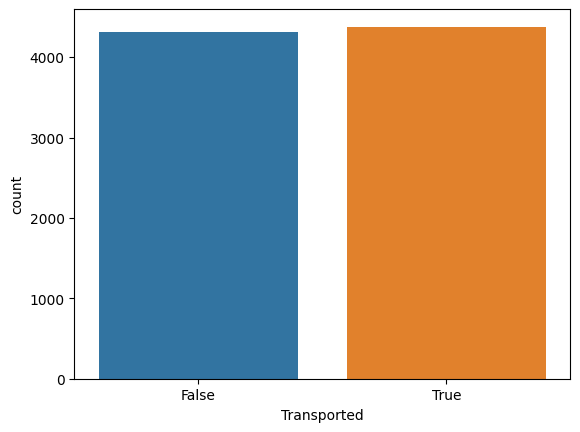

In [12]:
sns.countplot(x='Transported', data=train_data)


# Pre-processing


In [13]:
def preprocess_data(data, columns_with_missing_values):
    # Handle missing values
    for col in columns_with_missing_values:
        if data[col].dtype == 'object': 
            data[col].fillna(data[col].mode()[0], inplace=True)  
        else:
            data[col].fillna(data[col].median(), inplace=True)  

    # Extract the first letter from the cabin string to represent the cabin section
    data['CabinSection'] = data['Cabin'].apply(lambda x: x[0])
    data.drop(['Name','PassengerId','Cabin'], axis=1, inplace=True)

    # Encoding of categorical features and convert Boolean values to 1 or 0
    data = pd.get_dummies(data, columns=['HomePlanet', 'Destination', 'CabinSection','CryoSleep','VIP'])

    return data

In [14]:
train_data_preprocessed = preprocess_data(train_data, train_data_columns_with_missing_values)
train_data_preprocessed.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CabinSection_C,CabinSection_D,CabinSection_E,CabinSection_F,CabinSection_G,CabinSection_T,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1,0,0,...,0,0,0,1,0,0,1,0,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,0,0,...,0,0,0,1,0,0,1,0,1,0


# Split test and train datasets

In [15]:
X = train_data_preprocessed.drop('Transported', axis=1)
y = train_data_preprocessed['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model Evaluation


In [16]:
def plot_learning_curves(model, X, y, model_name):
    # Compute training and test scores for varying training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)
    
    # Calculate the mean of the training scores for each training set size
    train_mean = np.mean(train_scores, axis=1)
    
    # Calculate the mean of the test scores for each training set size
    test_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, label='Training accuracy')
    plt.plot(train_sizes, test_mean, label='Validation accuracy')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve: {model_name}')
    plt.legend()
    plt.show()


In [17]:
def compare_models(models, model_names, X_train, X_val, y_train, y_val, X, y):
    accuracy_scores = {}
        
    for model, model_name in zip(models, model_names):
        # Fit the model to the training data
        model.fit(X_train, y_train)
        # Predict the outcomes for the validation data
        y_pred = model.predict(X_val)
        # Calculate the accuracy score of the model's predictions
        accuracy = accuracy_score(y_val, y_pred)
        # Store the accuracy score in the dictionary with the model's name as the key
        accuracy_scores[model_name] = accuracy

        # Plot learning curves for the model
        plot_learning_curves(model, X, y, model_name)
    
    # Find the best model name by selecting the key with the highest accuracy score
    best_model_name = max(accuracy_scores, key=accuracy_scores.get)
    # Get the best accuracy score from the dictionary
    best_accuracy = accuracy_scores[best_model_name]
    # Retrieve the best model by finding its index in the model_names list and using it to index the models list
    best_model = models[model_names.index(best_model_name)]
    
    print(f"The best model is: {best_model_name} with its accuracy score: {best_accuracy:.4f}")
    
    return accuracy_scores, best_model

# Define the models to compare 

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
svc = SVC(random_state=0, probability=True)
knn = KNeighborsClassifier()
lr = LogisticRegression(random_state=0,max_iter=200)
xgb = XGBClassifier(random_state=0)

In [19]:
models = [rf, svc, knn, lr, xgb]
model_names = ['RandomForestClassifier', 'SVC', 'KNeighborsClassifier', 'LogisticRegression', 'XGBClassifier']

# Compare the models

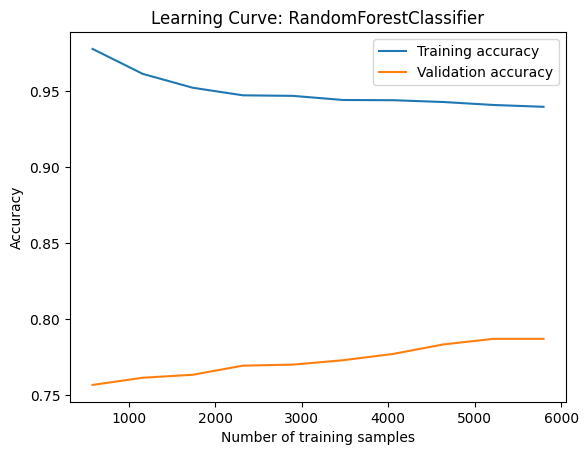

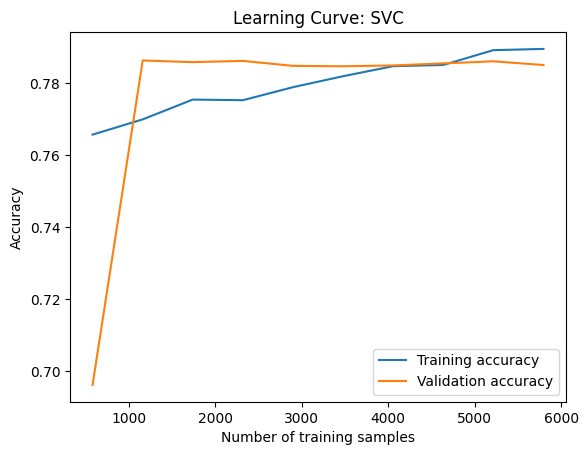

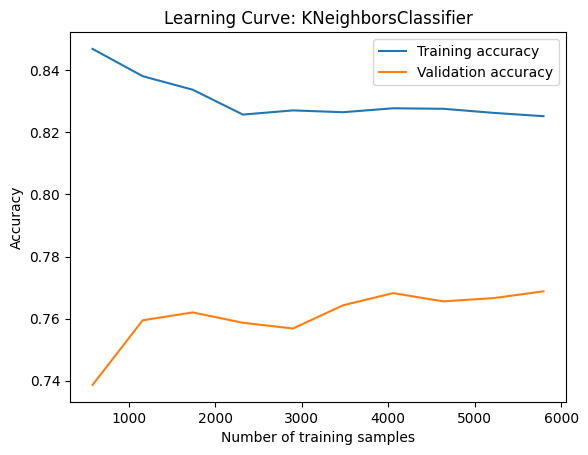

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


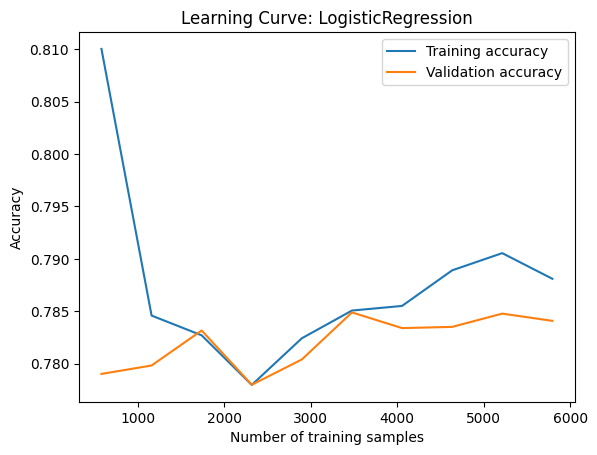

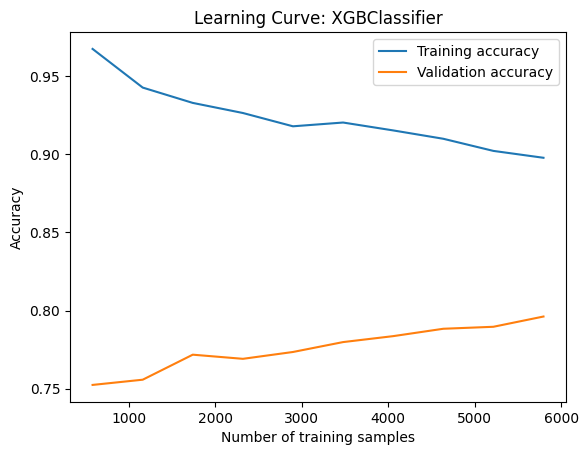

The best model is: XGBClassifier with its accuracy score: 0.7907


In [20]:
accuracy_scores, best_model = compare_models(models, model_names, X_train, X_test, y_train, y_test, X, y)


# Prepare the test data


In [21]:
test_data = pd.read_csv('test.csv')
test_data_copy = test_data.copy()

test_data_missing_values = test_data.isnull().sum()
test_data_columns_with_missing_values = [col for col in test_data.columns if test_data_missing_values[col] > 0]

#First submission

In [22]:
test_data_preprocessed = preprocess_data(test_data_copy, test_data_columns_with_missing_values)
test_predictions = best_model.predict(test_data_preprocessed)

# Create the submission file for the best model
submission_best_model = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],  
    'Transported': (test_predictions >= 0.5).astype(bool)
})
submission_best_model.to_csv('submission_best_model.csv', index=False)
!kaggle competitions submit -c spaceship-titanic -f submission_best_model.csv -m "submission_best_model"


100% 56.3k/56.3k [00:01<00:00, 30.5kB/s]
Successfully submitted to Spaceship Titanic

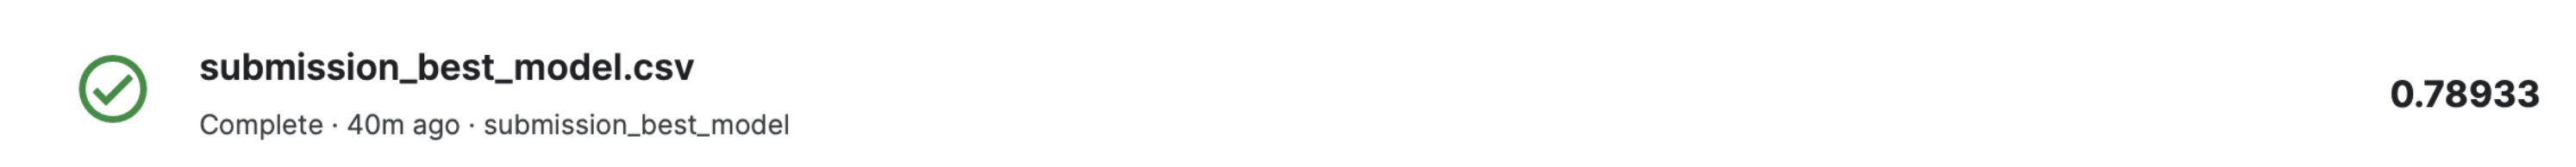

# Hyperparameter tuning of the best model


In [23]:
# Define a dictionary for the parameter grid to be used in a grid search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
}

In [24]:
# Create an XGBClassifier instance with specified parameters
xgb = XGBClassifier(eval_metric='mlogloss', tree_method='gpu_hist')
# Create a GridSearchCV instance for hyperparameter tuning using all available processors
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=10, n_jobs=-1)
# Record the start time
start_time = time.time()
#Train the GridSearchCV with the training data
grid_search.fit(X_train, y_train)
# Record the end time
end_time = time.time()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [25]:
# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_
# Retrieve the best model from the grid search
best_estimator = grid_search.best_estimator_

In [26]:
# Use the best estimator to make predictions on the validation set
y_pred = best_estimator.predict(X_test)
# Calculate the accuracy of the best estimator's predictions
accuracy = accuracy_score(y_test, y_pred)
# Calculate the time taken to complete the grid search
length = end_time - start_time
print(f"The best XGBClassifier with GridSearchCV has an accuracy score of: {accuracy:.4f} in a time of: {length:.4f} seconds")

The best XGBClassifier with GridSearchCV has an accuracy score of: 0.7941 in a time of: 1568.0761 seconds


# Submission of the best model fine tuned


In [27]:
test_predictions = best_estimator.predict(test_data_preprocessed)

finetuned_model_submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],  
    'Transported': (test_predictions >= 0.5).astype(bool)
})
finetuned_model_submission.to_csv('finetuned_model_submission.csv', index=False)


!kaggle competitions submit -c spaceship-titanic -f finetuned_model_submission.csv -m "best_estimator_model"

100% 56.2k/56.2k [00:01<00:00, 47.1kB/s]
Successfully submitted to Spaceship Titanic

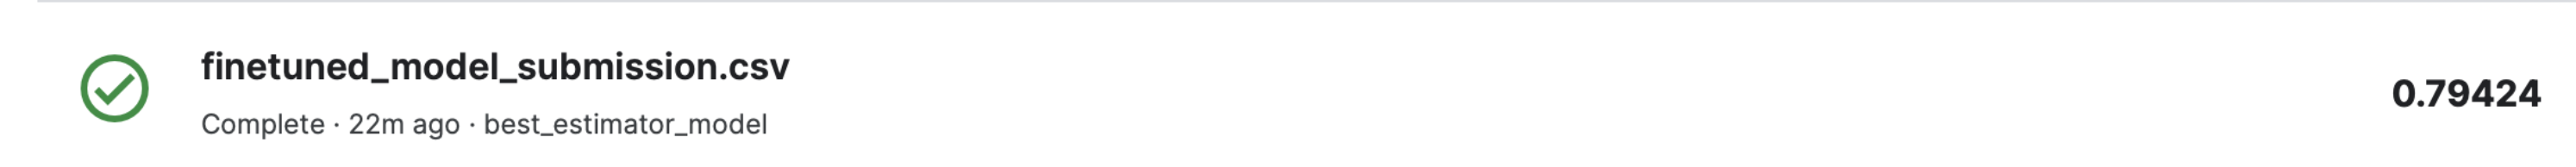